In [21]:
import torch 
from smartem.offline.train_mb_error_detector.NNtools import UNet as UNet_offline
from smartem.online.models import UNet as UNet_online
from smartem.segmentation import segmenter
from smartem.online import microscope,get_rescan_maps
from smartem import smartem
import h5py
from tqdm import tqdm
from skimage import measure
import pyvoi
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from skimage import io
import os

In [22]:
hdf5_path = "/storage2/projects/smartEM/em-vis/smartem-data-test.hdf5"
temp_dir = "/storage2/projects/smartEM/em-vis/new_temp/"

device = torch.device("cuda:1")

em2mb_model_mit = UNet_offline.UNet(1,2)
em2mb_model_core = UNet_online.UNet(1,2)
em2mb_path_mit = "../../pretrained_models/em2mb_best.pth"
errnet_path_mit = "../../pretrained_models/error_best.pth"
em2mb_path_core = "../../pretrained_models/em2mb_best_core.pth"
errnet_path_core = "../../pretrained_models/error_best_core.pth"

fast_dwt = 50
slow_dwt = 800
rescan_ratios = [0, 0.05, 0.1, 0.25, 0.5, 1.0]
valid_dwts = [25, 50, 75, 100, 125, 150, 200, 300, 400, 500, 600, 800, 1000, 1200]

In [23]:
Iseg_mit = segmenter.Segmenter(em2mb_path_mit, segmenter_function = measure.label, device=device)
Iseg_mit.set_model(model_class=em2mb_model_mit)

Iseg_core = segmenter.Segmenter(em2mb_path_core, segmenter_function = measure.label, device=device)
Iseg_core.set_model(model_class=em2mb_model_core)

In [24]:
data_voi = []
data_rescan_ratio = []
data_methods = []

with h5py.File(hdf5_path, 'r') as f:
    for rescan_ratio in tqdm(rescan_ratios, desc="varying rescan ratio..."):
        for reg in tqdm(f.keys(), desc="segmenting regions...", disable=True):
            group = f[reg]
            dwts = [int(dwt) for dwt in list(group.keys())]
            dwts.sort()
            slowest_dwt = dwts[-1]

            slow_em = group[f"{slowest_dwt}/im"][()]

            labels_slow_mit = Iseg_mit.get_labels(slow_em)
            labels_slow_core = Iseg_core.get_labels(slow_em)

            image_names = {}

            for dwt_save in dwts:
                im = group[f"{dwt_save}/im"][()]
                im_file_path = Path(temp_dir) / f"test_{reg}_{dwt_save}.png"
                if not os.path.isfile(im_file_path):
                    io.imsave(im_file_path, im)

                image_names[dwt_save] = str(im_file_path)

            params = {"images_ns": image_names}
            my_microscope = microscope.FakeDataMicroscope(params=params)

            # make smartem object MIT 
            params_us = {
                "em2mb_net": em2mb_path_mit,
                "error_net": errnet_path_mit,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": False,
            }
            get_rescan_map = get_rescan_maps.GetRescanMapMembraneErrors(params=params_us)

            my_smart_em_mit = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map
            )
            my_smart_em_mit.initialize(unet_version="offline")


            # make smartem object core
            params_core = {
                "em2mb_net": em2mb_path_core,
                "error_net": errnet_path_core,
                "device": device,
                "pad": 0,
                "rescan_p_thres": None, # 0.1
                "rescan_ratio":rescan_ratio,#add a number to force a specific rescan ratio
                "search_step": 0.01,
                #"do_clahe": True,
            }
            get_rescan_map_core = get_rescan_maps.GetRescanMapMembraneErrors(params=params_core)

            my_smart_em_core = smartem.SmartEM(
                microscope=my_microscope, get_rescan_map=get_rescan_map_core
            )
            my_smart_em_core.initialize(unet_version="online")

            # Acquire images
            params = {"fast_dwt": fast_dwt*1e-9, "slow_dwt": slow_dwt*1e-9, "plot": False}
            fast_em, slow_em, rescan_map_mit, *_ = my_smart_em_mit.acquire(params=params)
            fast_em, slow_em, rescan_map_core, *_ = my_smart_em_core.acquire(params=params)

            # Segment
            merged_em_mit = fast_em.copy()
            merged_em_mit[rescan_map_mit] = slow_em[rescan_map_mit]
            labels_mit = Iseg_mit.get_labels(merged_em_mit)

            merged_em_core = fast_em.copy()
            merged_em_core[rescan_map_core] = slow_em[rescan_map_core]
            labels_core = Iseg_core.get_labels(merged_em_core)

            # Compute VI
            voi_mit = pyvoi.VI(labels_slow_mit.flatten(), labels_mit.flatten())[0].item()
            voi_core = pyvoi.VI(labels_slow_core.flatten(), labels_core.flatten())[0].item()

            data_voi.append(voi_mit)
            data_rescan_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM trained @ MIT: {fast_dwt}/{slow_dwt}ns")

            data_voi.append(voi_core)
            data_rescan_ratio.append(rescan_ratio)
            data_methods.append(f"SmartEM from Core: {fast_dwt}/{slow_dwt}ns")


data = {"Method": data_methods, "Variation of Information from Slow Dwell Time Segmentation": data_voi, "Rescan Ratio": data_rescan_ratio}
df = pd.DataFrame(data=data)

varying rescan ratio...:   0%|          | 0/6 [00:00<?, ?it/s]/home/tommy-local/projects/smartem/SmartEM/smartem/online/get_rescan_maps.py:188: UserWarning: This is very slow in the current implementation.
  warnings.warn("This is very slow in the current implementation.")
varying rescan ratio...: 100%|██████████| 6/6 [08:30<00:00, 85.14s/it]


<Axes: xlabel='Rescan Ratio', ylabel='Variation of Information from Slow Dwell Time Segmentation'>

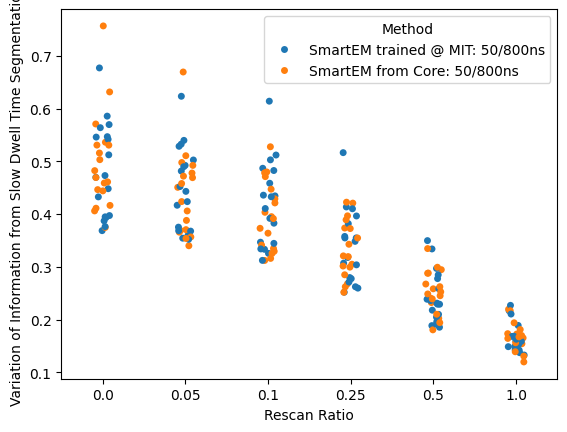

In [20]:
sns.stripplot(df, x="Rescan Ratio", y="Variation of Information from Slow Dwell Time Segmentation", hue="Method")